<h1 style="text-align: center;">LSTM Model for Stock Prediction</h1>

<h3>Import of Libraries</h3>

In [9]:
import os

from typing import Tuple, Dict

import math
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from re import X

import keras;
from kerastuner import HyperModel, RandomSearch
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
from keras.layers import Dropout

<h3>Functions for Loading preprocessed data</h3>

In [10]:
def import_data_from_csv(path: str):
    """
    Imports data from a csv file and returns a pandas dataframe.
    """
    return pd.read_csv(path)

<h3>Functions for preparing data for LSTM model</h3>

In [11]:
def extract_features_required_for_training(df: pd.DataFrame, features: list[str]) -> pd.DataFrame:
    """
    Extracts features required for training.
    """
    return df[features]


def split_data_into_training_and_test_sets(df: pd.DataFrame, window_start: int, window_end: int, test_size: float, columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, float]]:
    """
    Normalizes the entire data set, then splits it into training and test sets based on the given ratio.
    """
    data_count = window_end - window_start
    test_data_count = int(data_count * test_size)

    end_of_training_data = window_start + test_data_count

    df, max_values = normalize_data(df, columns, window_start, window_end)

    return df.iloc[window_start : end_of_training_data], df.iloc[end_of_training_data : window_end], max_values


def normalize_data(df: pd.DataFrame, columns: list[str], start: int, end: int):
    """
    Normalizes the data in the given segment.
    """
    max_values = {}
    for column in columns:
        max_value = df.iloc[start:end][column].max()
        df.loc[start:end, column] = df.loc[start:end, column] / max_value
        max_values[column] = max_value

    return df, max_values


def denormalize_data(data_array: np.ndarray, columns: list[str], max_values: dict):
    """
    Denormalizes the data in the given segment.
    """
    for column in columns:
        data_array[:] = data_array[:] * max_values[column]

    return data_array


def create_dataset(dataset: pd.DataFrame, time_step = 1) -> tuple[np.ndarray, np.ndarray]:
    """
    Creates a dataset.
    """
    dataX,dataY = [],[]

    for i in range(len(dataset)-time_step-1):
        dataX.append(dataset.iloc[i:(i+time_step), 0])
        dataY.append(dataset.iloc[i + time_step, 0])

    return np.array(dataX),np.array(dataY)

<h3>Function for Building the LSTM model</h3>

In [12]:
def build_model(input_shape):
    """
    Builds the LSTM model.
    """
    model = Sequential()
    model.add(LSTM(75, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.1))

    model.add(LSTM(75, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(75, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(75))
    model.add(Dropout(0.1))

    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.1))

    model.add(Dense(512, activation="relu")) 
    model.add(Dropout(0.1))

    model.add(Dense(1, activation="relu"))
    
    model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["mae", 'mape'])
    model.summary()

    return model

<h3>Function for Hyperparameter optimization</h3>

In [13]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=25, max_value=75, step=10), 
                    return_sequences=True, 
                    input_shape=self.input_shape))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

        for i in range(hp.Int('layers', 1, 3)):
            model.add(LSTM(units=hp.Int('units_' + str(i), min_value=25, max_value=75, step=10), 
                        return_sequences=True))
            model.add(Dropout(hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

        model.add(LSTM(units=hp.Int('units_final', min_value=32, max_value=512, step=32)))
        model.add(Dropout(hp.Float('dropout_final', min_value=0.0, max_value=0.5, step=0.1)))

        for i in range(hp.Int('dense_layers', 1, 3)):
            model.add(Dense(hp.Int('dense_units_' + str(i), min_value=128, max_value=512, step=64), 
                            activation=hp.Choice('dense_activation_' + str(i), values=['relu', 'tanh', 'sigmoid'])))
            model.add(Dropout(hp.Float('dense_dropout_' + str(i), min_value=0.0, max_value=0.5, step=0.1)))

        model.add(Dense(1, activation="relu"))

        model.compile(loss="mse", 
                    optimizer=keras.optimizers.Adam(
                        hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                    metrics=["mae", 'mape'])

        return model

<h3>Functions for representing data</h3>

In [14]:
def plot_data(loaded_data, title: str, xlabel: str, ylabel: str, datacolumn: str):
    """
    Plots the data from the dataframe.
    """
    plt.figure(figsize=(16,6))
    plt.title(title)
    plt.plot(loaded_data[datacolumn])
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.show()


def plot_data_list(loaded_data_list, title: str, xlabel: str, ylabel: str, datacolumns: list):
    """
    Plots the data from the dataframe.
    """
    plt.figure(figsize=(16,6))
    plt.title(title)
    for loaded_data, datacolumn in zip(loaded_data_list, datacolumns):
        plt.plot(loaded_data, label=datacolumn)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.legend()
    plt.show()

<h3>Function for fiting the model</h3>

In [15]:
def lstm_prediction(file: str):
    file_name = file.split("/")[-1]
    file_name_without_extension = file_name.split(".")[0]

    loaded_data = import_data_from_csv(file)
    extracted_data = extract_features_required_for_training(loaded_data, ["Adj Close"])

    time_step = 5
    number_of_intervals = 5
    percentage_of_test_interval_data = 0.8

    interval_size = int(extracted_data.shape[0] / number_of_intervals)

    X_training_data, Y_training_data = [], []
    X_test_data, Y_test_data = [], []
    max_values_list = []

    for i in range(number_of_intervals):
        start = i * interval_size
        end = start + interval_size

        if(i == number_of_intervals - 1):
            end = extracted_data.shape[0]

        training_data_interval, test_data_interval, max_values = split_data_into_training_and_test_sets(extracted_data, start, end, percentage_of_test_interval_data, ["Adj Close"])
        
        X_train, Y_train =  create_dataset(training_data_interval, time_step)
        X_test, Y_test =  create_dataset(test_data_interval, time_step)

        if(i != 0):
            X_train = np.concatenate((X_test_data[i - 1], X_train))
            Y_train = np.concatenate((Y_test_data[i - 1], Y_train))

        X_training_data.append(X_train)
        Y_training_data.append(Y_train)

        X_test_data.append(X_test)
        Y_test_data.append(Y_test)

        max_values_list.append(max_values)

    X_train_shape = (X_training_data[0].shape[1], 1)
    #lstm_model = build_model(X_train_shape)

    predictions_list = []
    actuals_list = []

    for i in range(number_of_intervals):
        X_training_data_interval = X_training_data[i]
        Y_training_data_interval = Y_training_data[i]
        X_test_data_interval = X_test_data[i]
        Y_test_data_interval = Y_test_data[i]
        
        file_path = "checkpoints/" + file_name_without_extension + "/lstm-" + str(i + 1) + ".keras"

        if(os.path.exists(file_path)):
            lstm_model = load_model(file_path)
        else:
            file_path_previos = "checkpoints/" + file_name_without_extension + "/lstm-" + str(i) + ".keras"

            if(os.path.exists(file_path_previos)):
                lstm_model = load_model(file_path_previos)

            X_training_data_interval = np.reshape(X_training_data_interval, (X_training_data_interval.shape[0], X_training_data_interval.shape[1], 1))

            #t_hist = lstm_model.fit(X_training_data_interval, Y_training_data_interval, batch_size = 15, epochs = 50)
            ###Hyperparameter tuning
            hypermodel = LSTMHyperModel(input_shape=X_train_shape)
            tuner = RandomSearch(
                hypermodel,
                objective='val_loss',
                max_trials=20,
                executions_per_trial=2,
                directory='tuning_results',
                project_name='lstm'+file_name_without_extension+str(i))  # Add interval index to project name to create a new tuning project for each interval

            # Hyperparameter tuning for the current interval
            tuner.search(X_training_data_interval, Y_training_data_interval,
                        epochs=20,
                        validation_data=(X_test_data_interval, Y_test_data_interval))

            # Get the optimal hyperparameters
            best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

            # Build the model with the optimal hyperparameters and train it on the data for the current interval
            lstm_model = tuner.hypermodel.build(best_hps)
            t_hist = lstm_model.fit(X_training_data_interval, Y_training_data_interval, batch_size = 15, epochs = 50)
            
            pd.DataFrame(t_hist.history).plot(figsize=(8,5))
            plt.show()

            lstm_model.save(file_path)
        
        X_test_data_interval = np.reshape(X_test_data_interval, (X_test_data_interval.shape[0], X_test_data_interval.shape[1] ,1))
        predictions = lstm_model.predict(X_test_data_interval)

        rmse = np.sqrt(np.mean(((predictions - Y_test_data_interval) ** 2)))
        print("RSME: " + str(rmse))

        denormalized_predictions = denormalize_data(predictions, ["Adj Close"], max_values_list[i])
        denormalized_actuals = denormalize_data(Y_test_data_interval, ["Adj Close"], max_values_list[i])
        plot_data_list([denormalized_predictions.flatten(), denormalized_actuals.flatten()], 'Predictions vs Actual for ' + str(i+1) + '. iteration of ' + file_name_without_extension, 'Date', 'Adj Close Price USD ($)', ['Predictions', 'Actual'])

        predictions_list = np.concatenate((predictions_list, denormalized_predictions.flatten()))
        actuals_list = np.concatenate((actuals_list, denormalized_actuals.flatten()))


    plot_data_list([predictions_list, actuals_list], 'Predictions vs Actual', 'Date', 'Adj Close Price USD ($)', ['Predictions', 'Actual'])

<h3>Main function</h3>

C:\Users\User\AppData\Local\Temp\ipykernel_40780\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


4/4 [==============================] - 1s 7ms/step
RSME: 0.03695564857869123


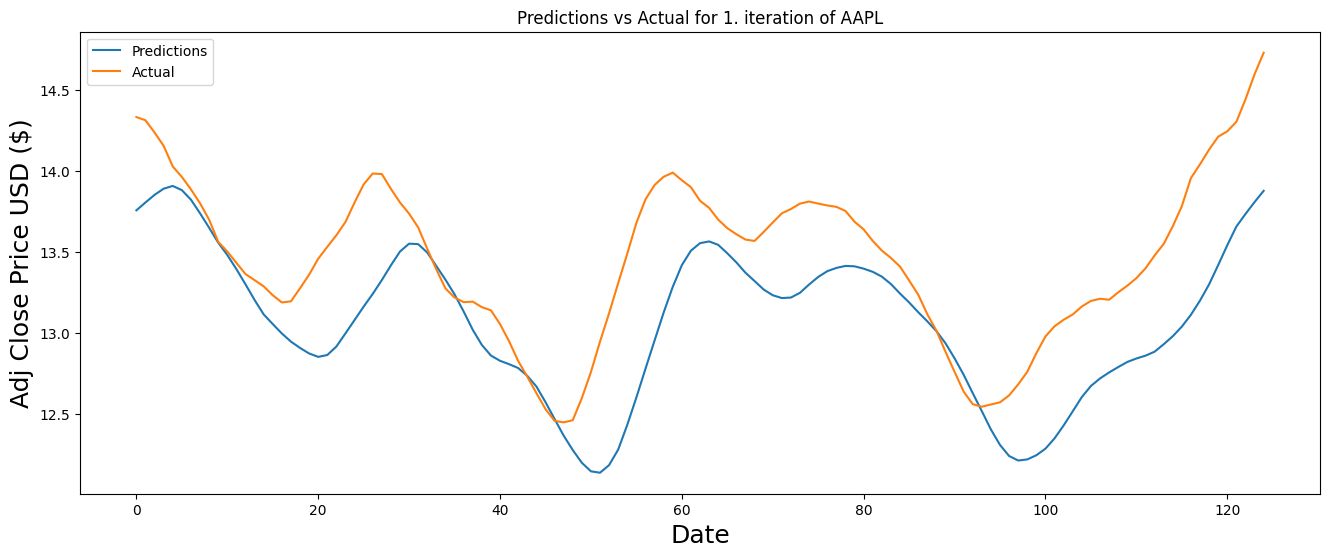

4/4 [==============================] - 1s 7ms/step
RSME: 0.09670366361795196


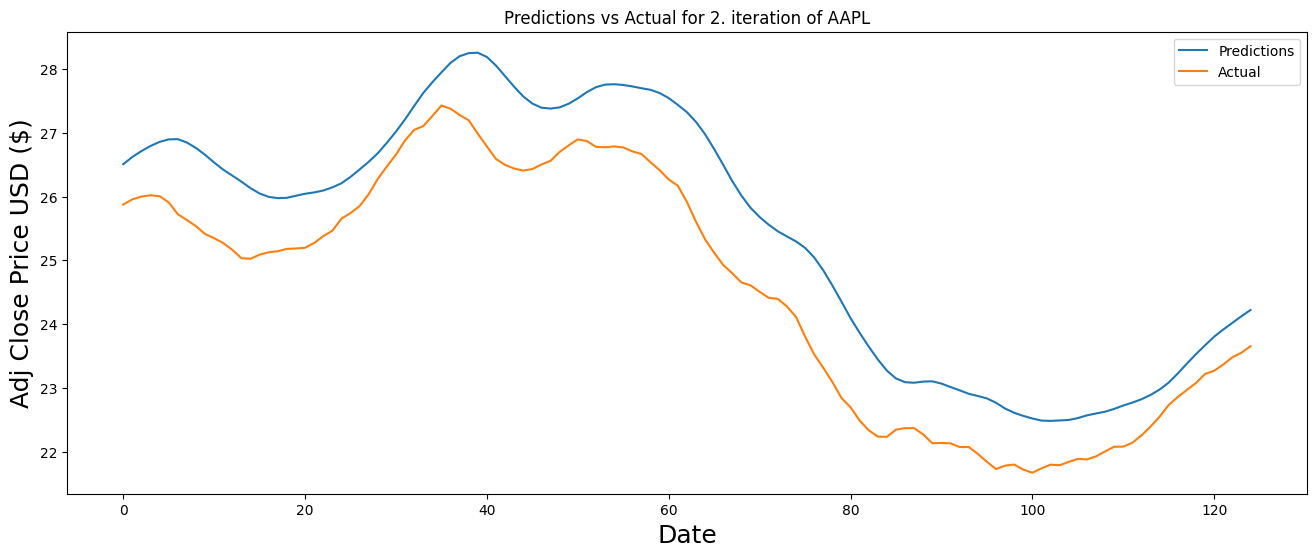

4/4 [==============================] - 1s 8ms/step
RSME: 0.11185404405848322


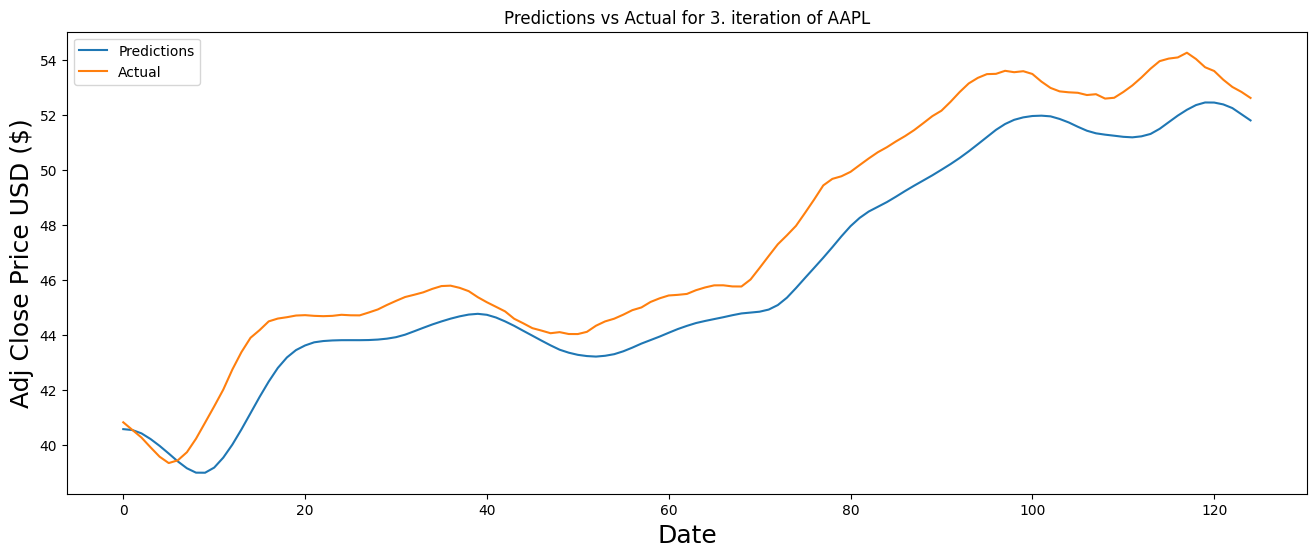

4/4 [==============================] - 2s 9ms/step
RSME: 0.05799415532961902


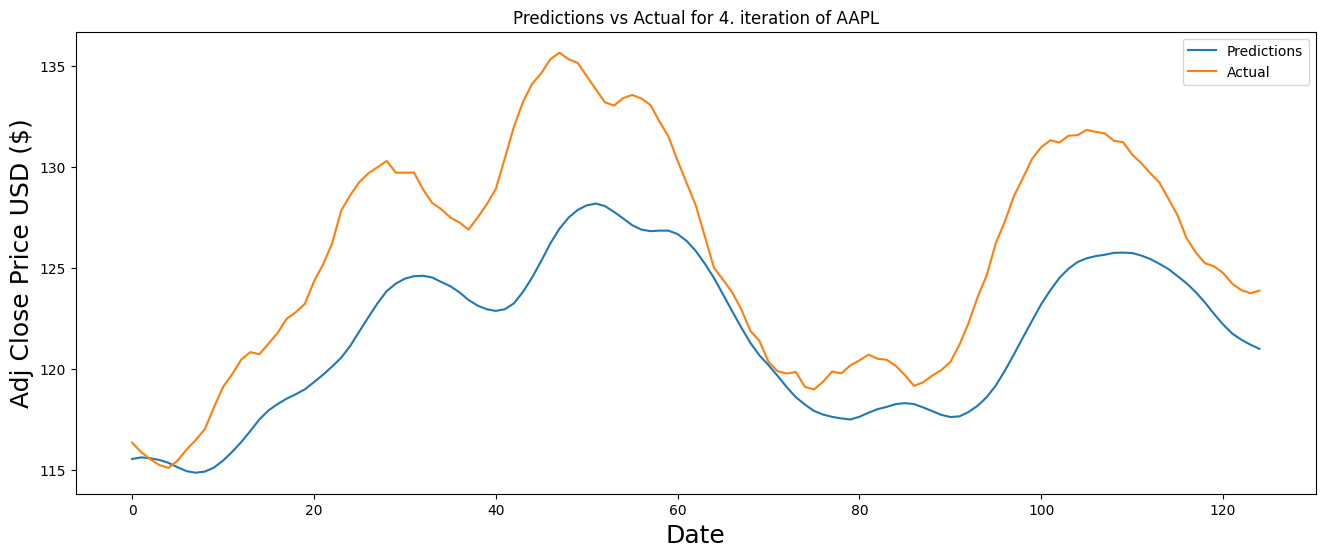

4/4 [==============================] - 1s 12ms/step
RSME: 0.057474121759846335


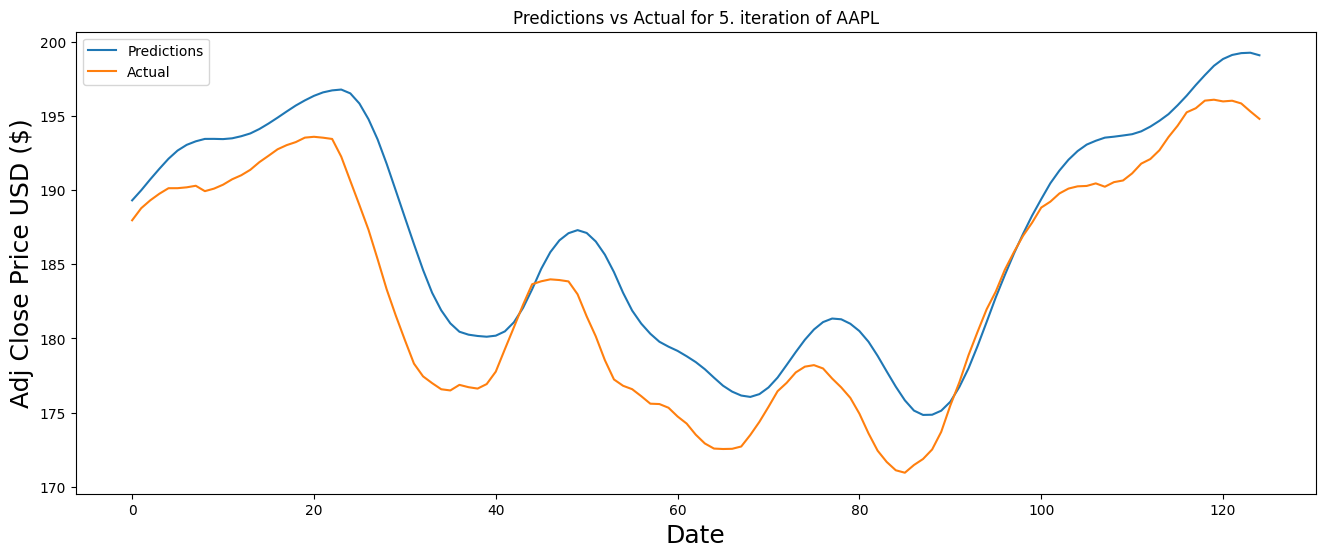

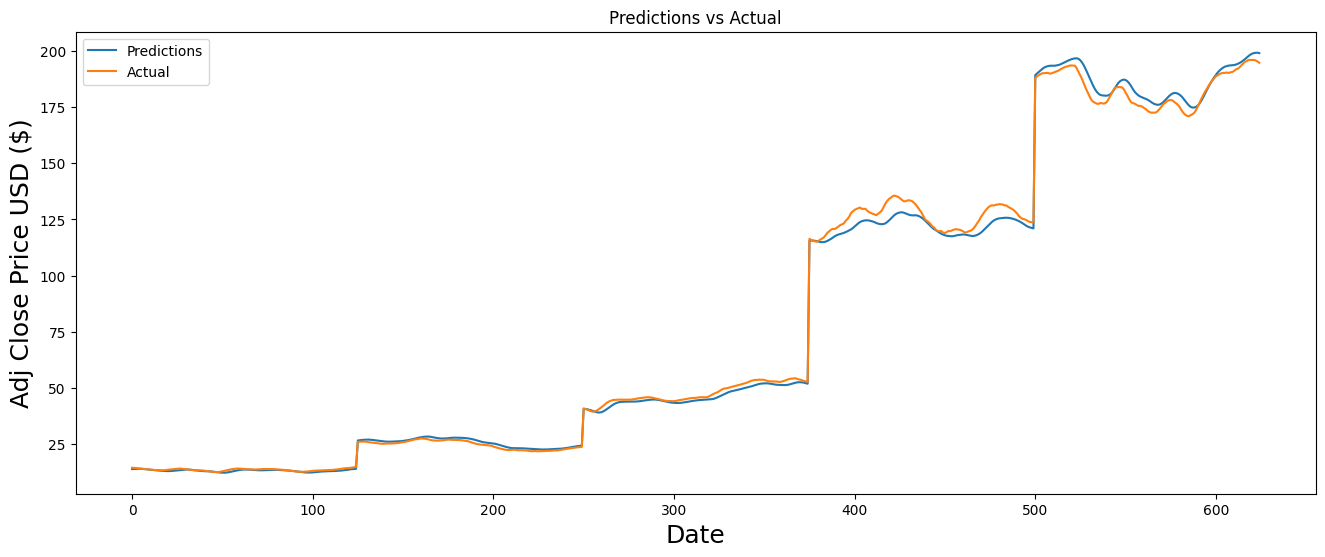

C:\Users\User\AppData\Local\Temp\ipykernel_40780\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


4/4 [==============================] - 1s 6ms/step
RSME: 0.09932858857872565


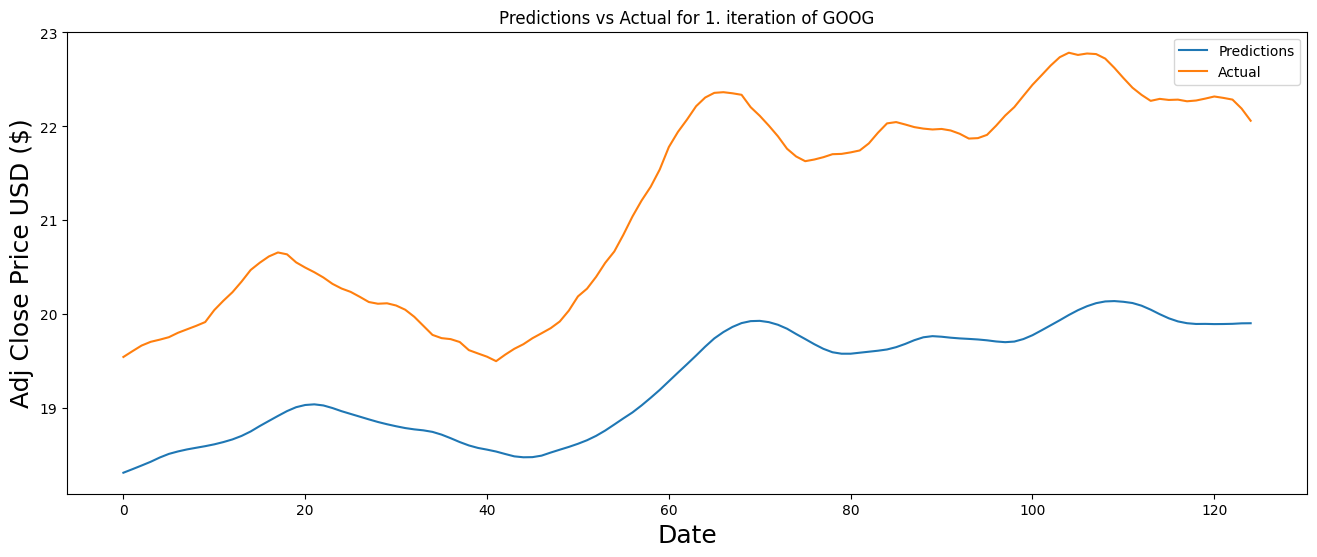

4/4 [==============================] - 1s 9ms/step
RSME: 0.08701314391181598


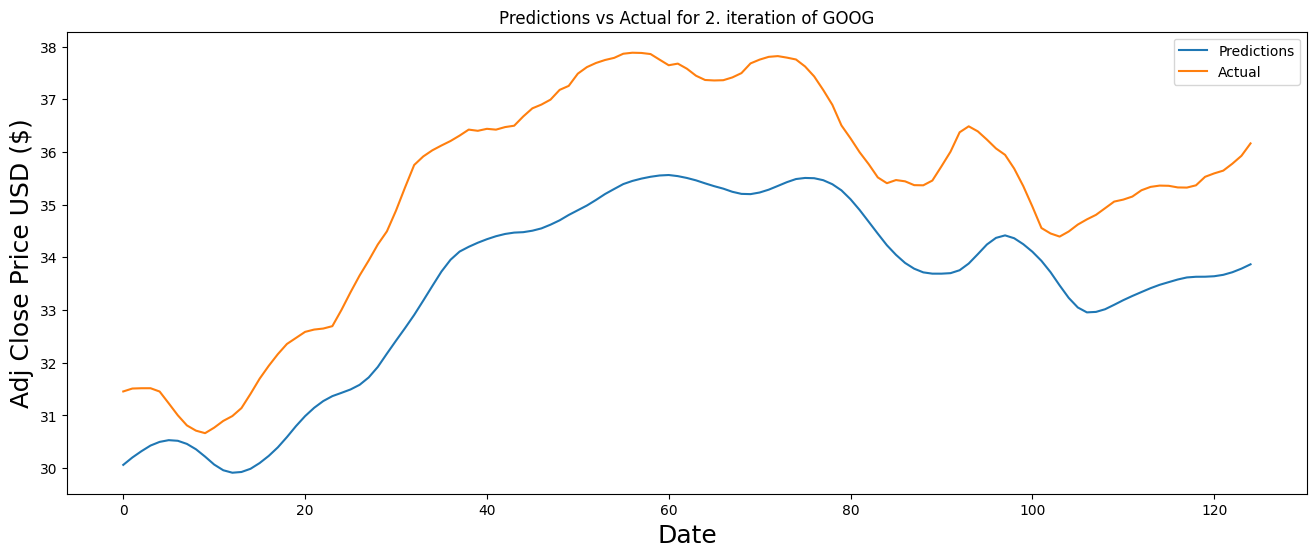

4/4 [==============================] - 2s 7ms/step
RSME: 0.07319777955002972


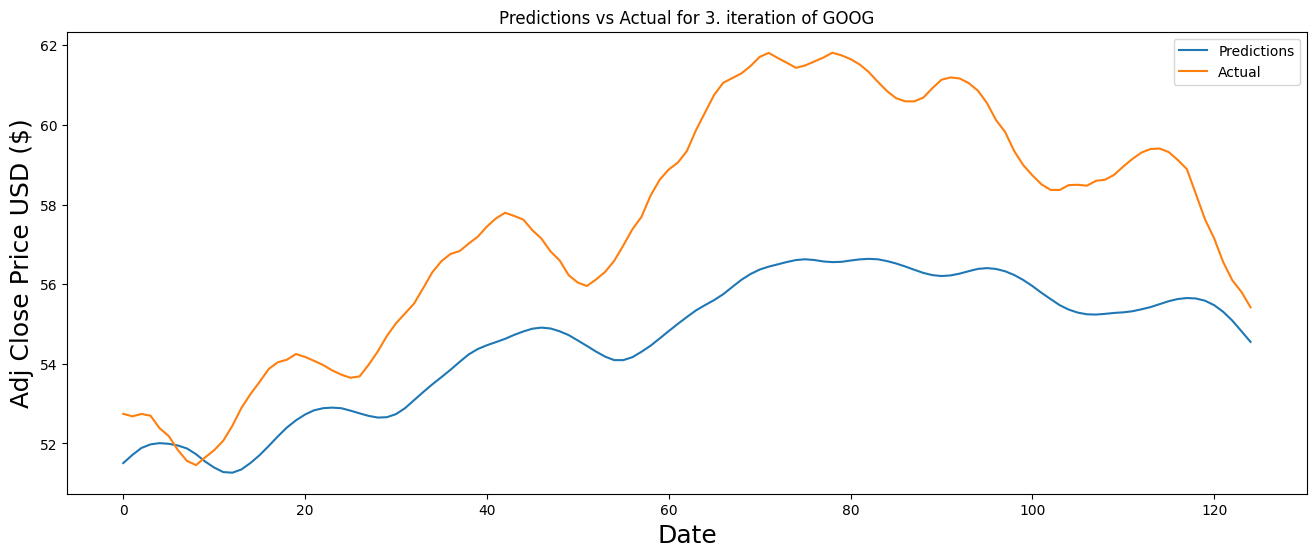

4/4 [==============================] - 1s 7ms/step
RSME: 0.12350072753000721


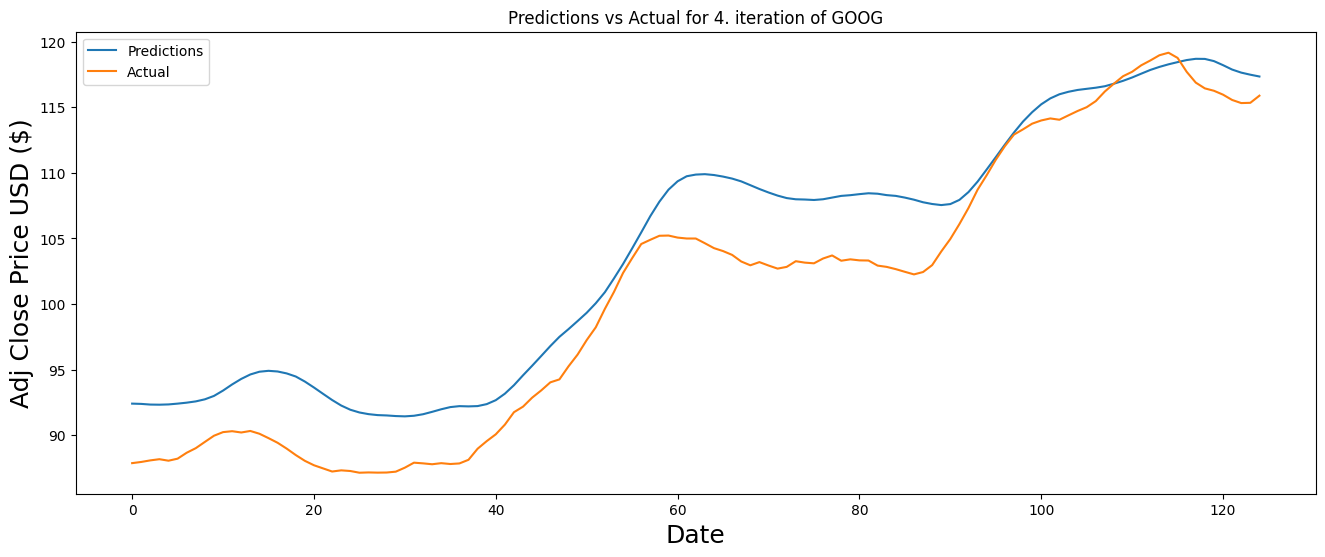

4/4 [==============================] - 2s 6ms/step
RSME: 0.05530165689248951


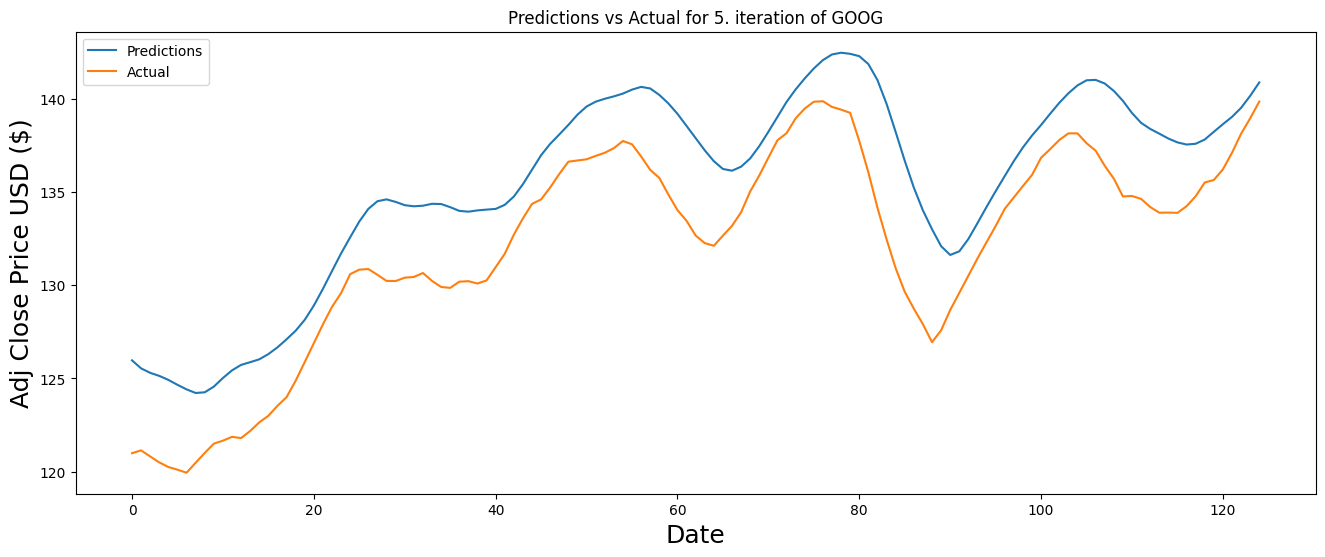

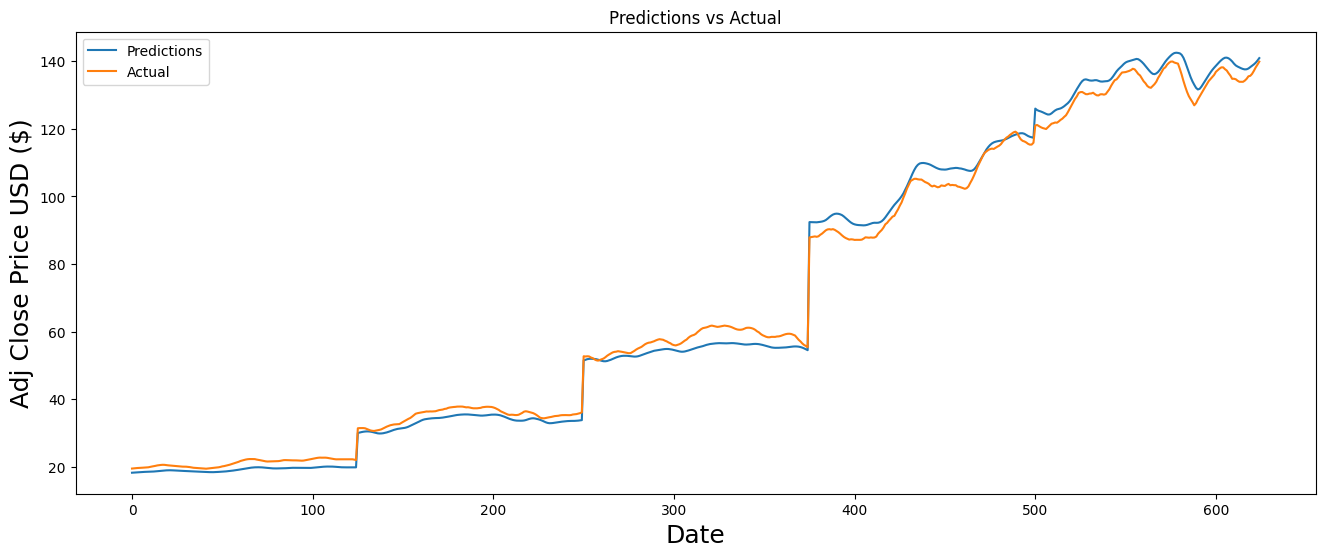

C:\Users\User\AppData\Local\Temp\ipykernel_40780\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


4/4 [==============================] - 2s 6ms/step
RSME: 0.11262484945706935


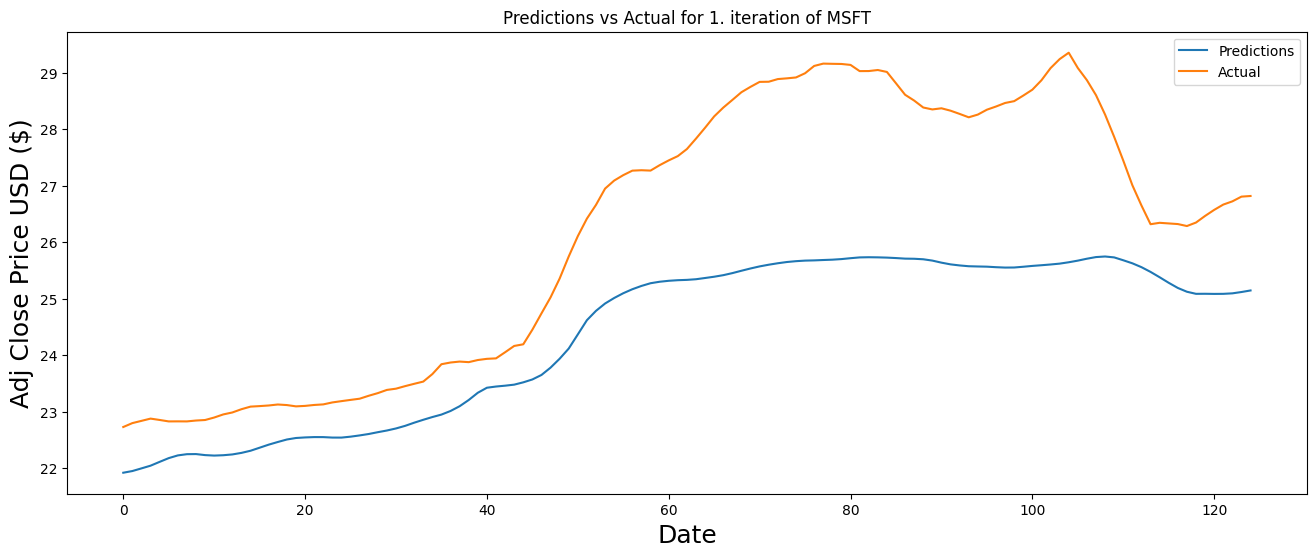

4/4 [==============================] - 2s 11ms/step
RSME: 0.09032585017312944


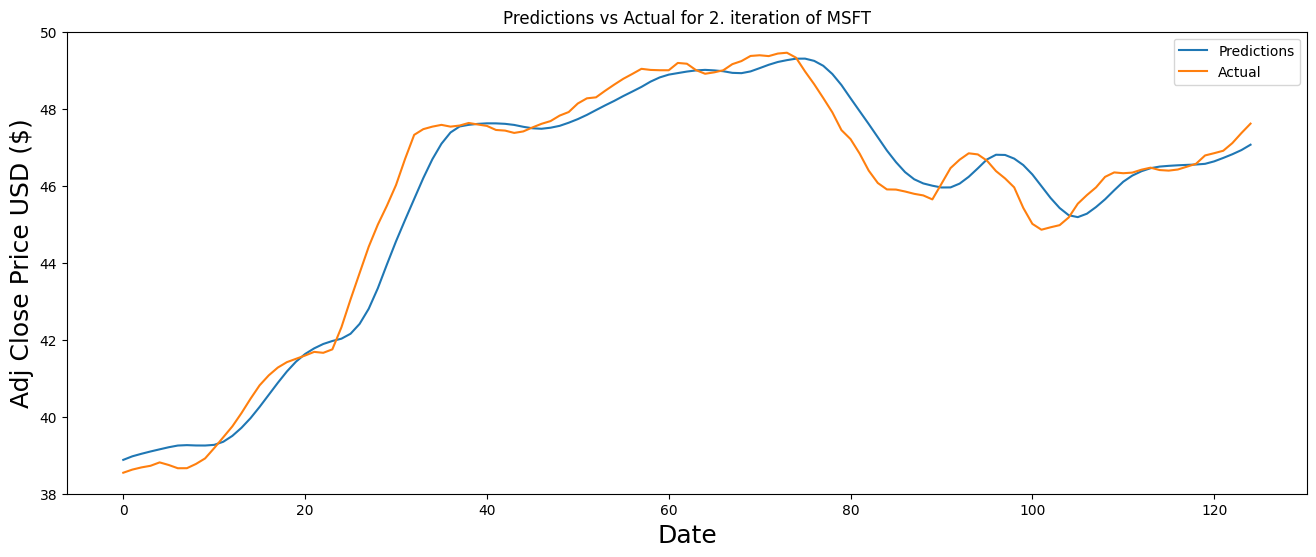

4/4 [==============================] - 1s 7ms/step
RSME: 0.07652024386368561


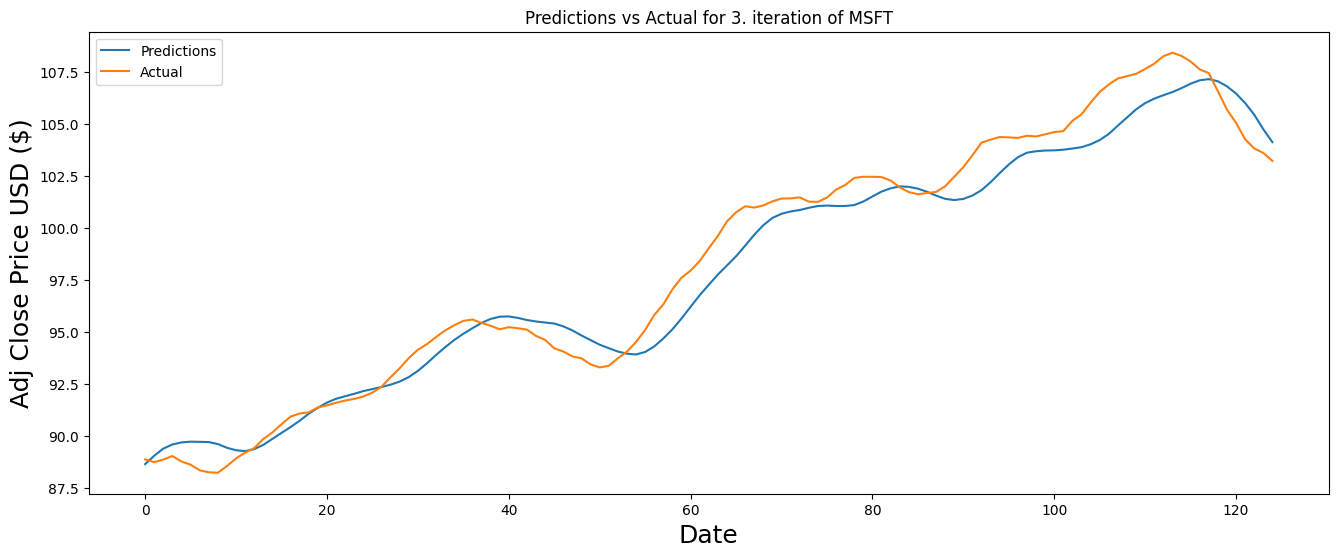

4/4 [==============================] - 1s 7ms/step
RSME: 0.07842672906660085


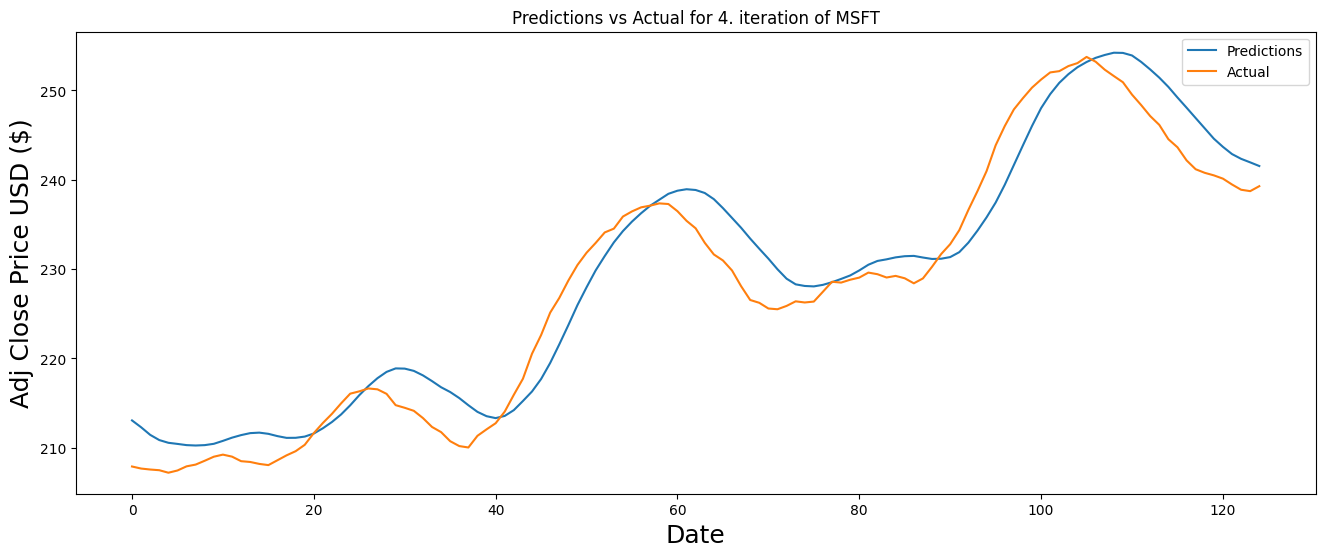

4/4 [==============================] - 2s 10ms/step
RSME: 0.07961457333257776


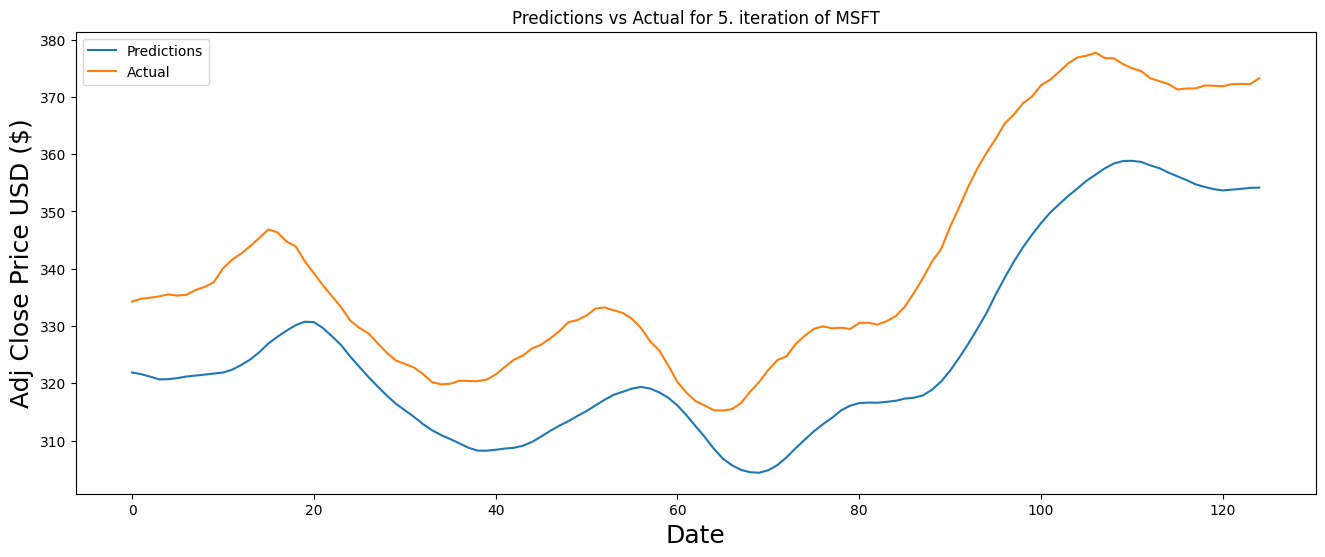

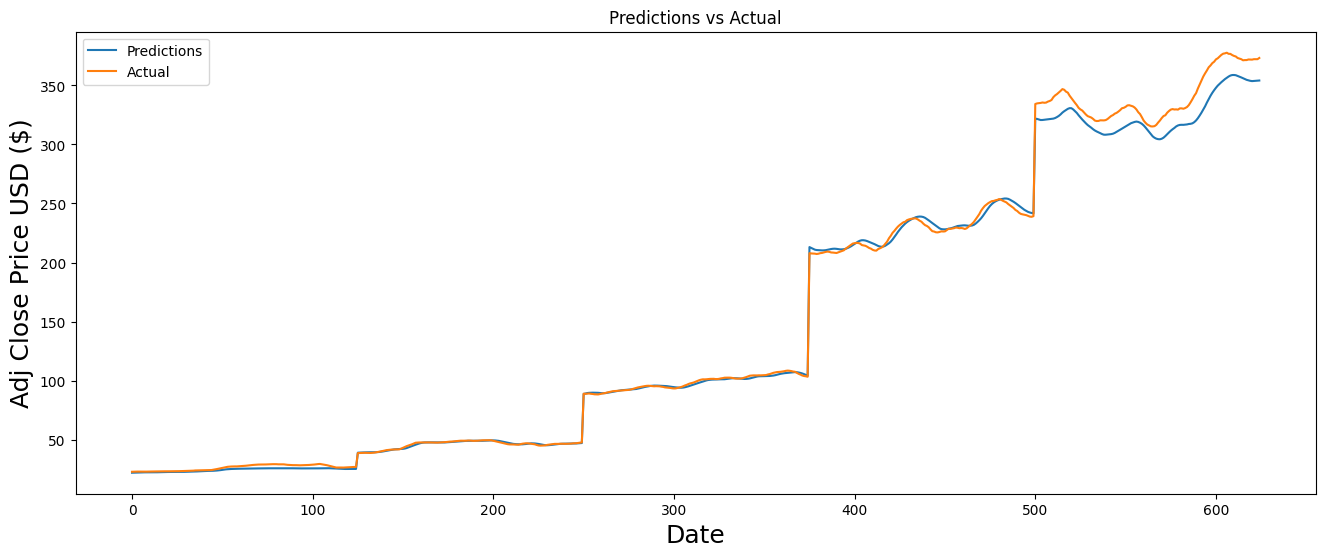

C:\Users\User\AppData\Local\Temp\ipykernel_40780\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


4/4 [==============================] - 2s 6ms/step
RSME: 0.13147098108208594


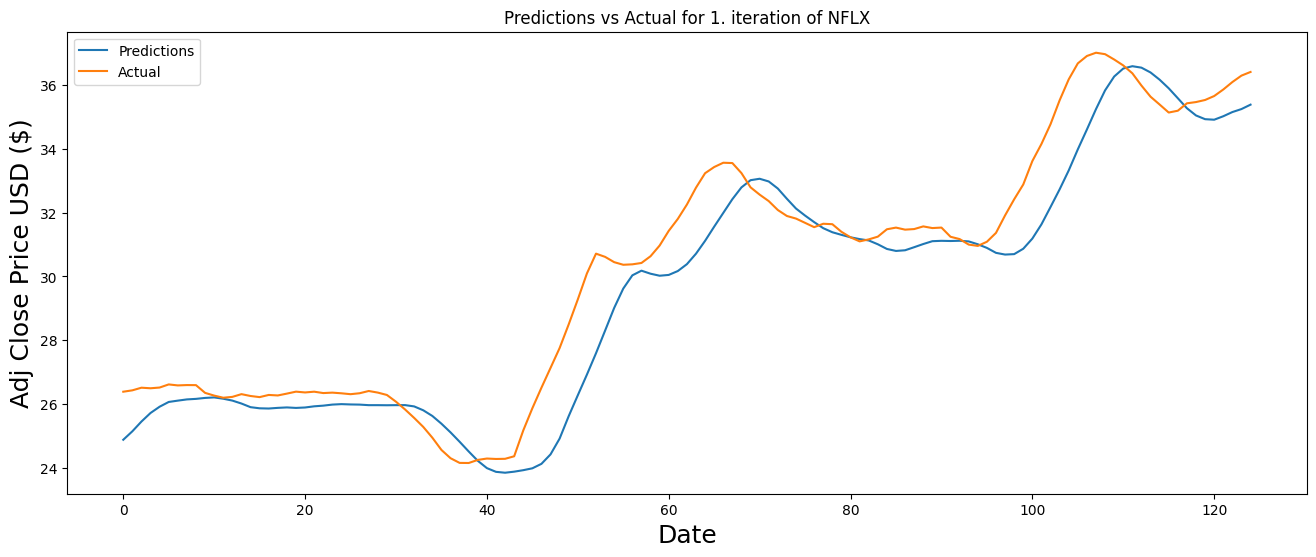

4/4 [==============================] - 2s 7ms/step
RSME: 0.11681231272025543


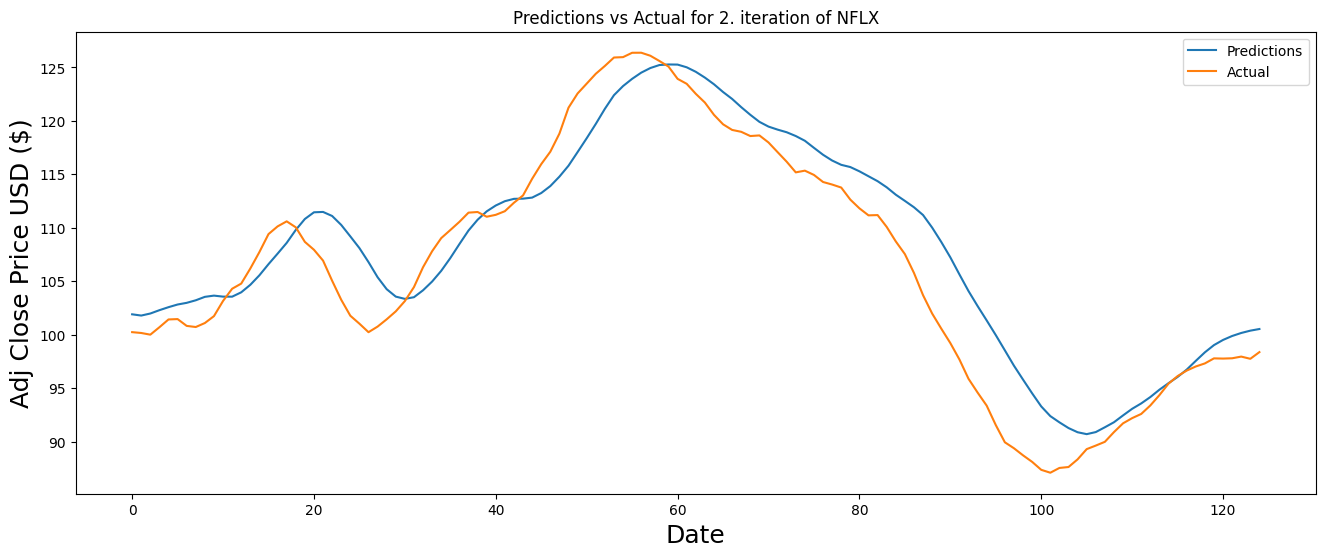

4/4 [==============================] - 2s 6ms/step
RSME: 0.08865071870486885


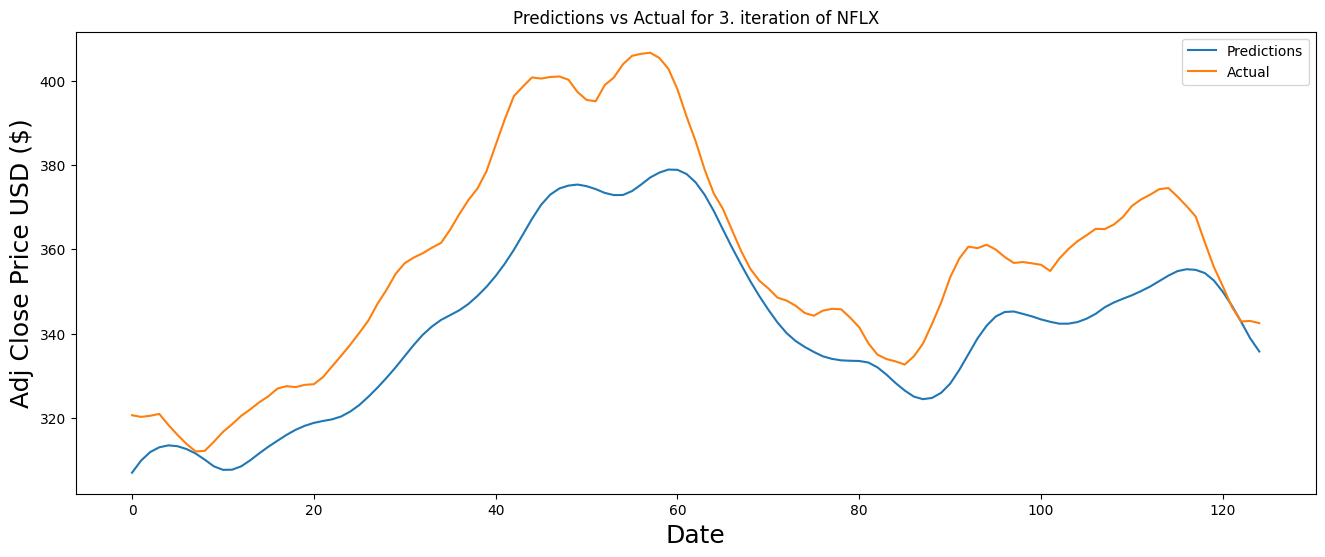

4/4 [==============================] - 2s 6ms/step
RSME: 0.05148340401823314


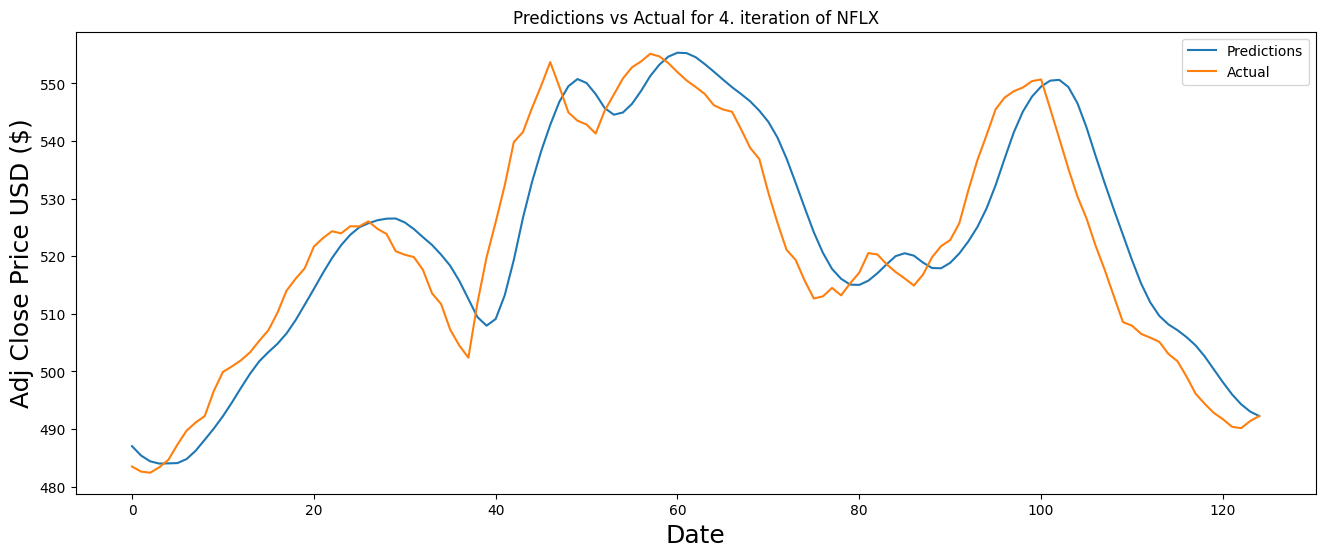

4/4 [==============================] - 2s 6ms/step
RSME: 0.06339033920203085


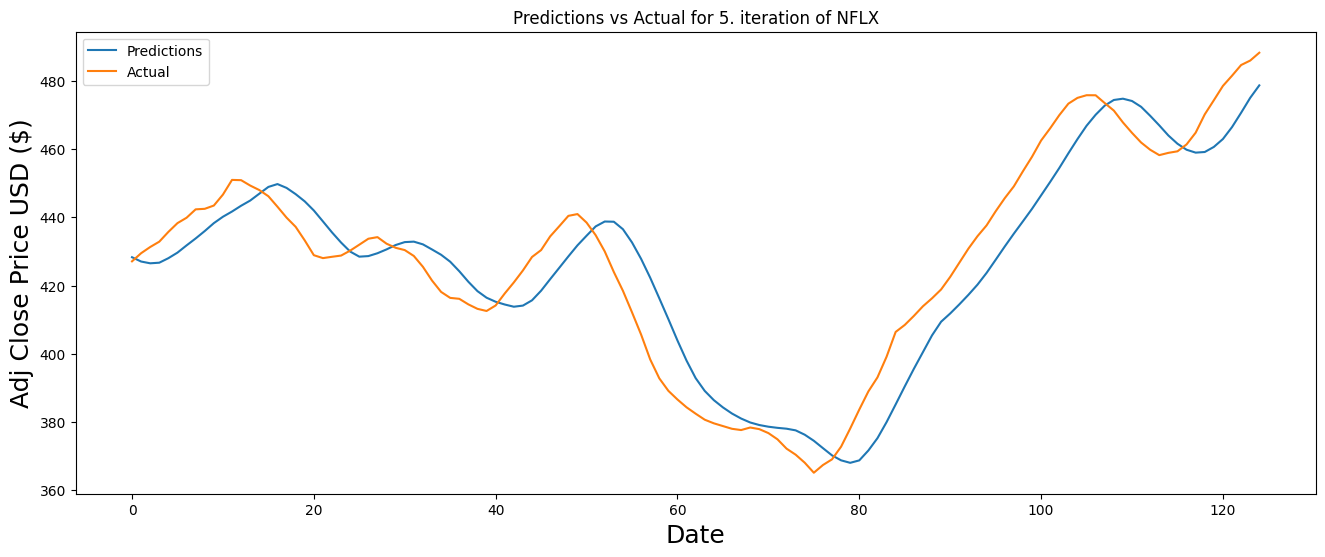

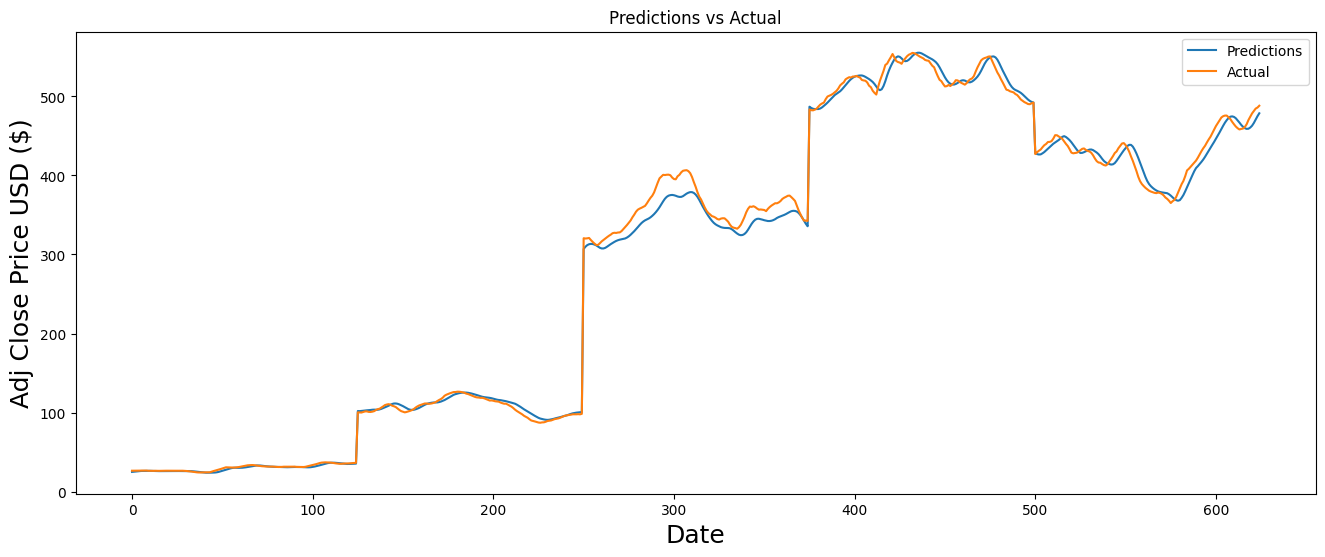

C:\Users\User\AppData\Local\Temp\ipykernel_40780\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


4/4 [==============================] - 1s 5ms/step
RSME: 0.04958423499856937


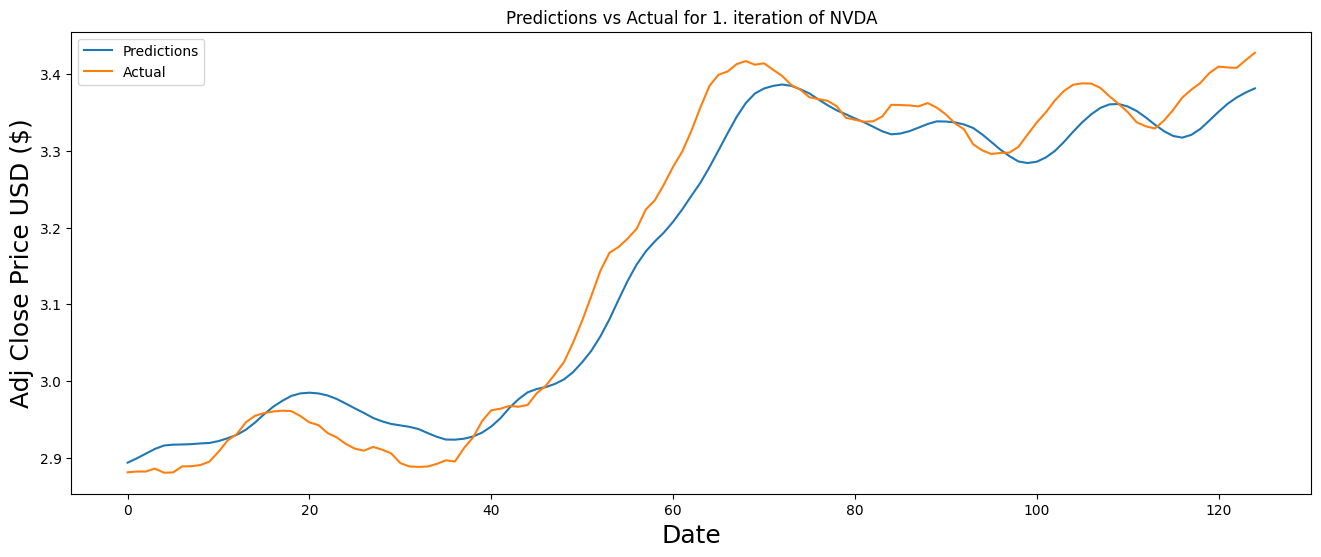

4/4 [==============================] - 2s 5ms/step
RSME: 0.12705757849532673


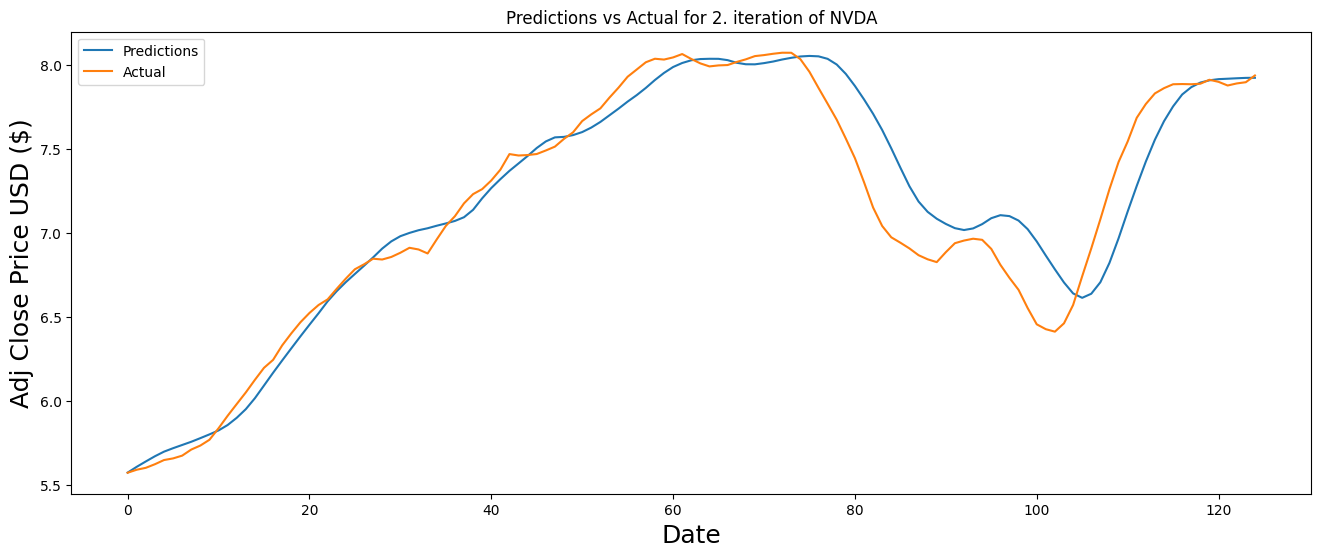

4/4 [==============================] - 2s 5ms/step
RSME: 0.0637968379659141


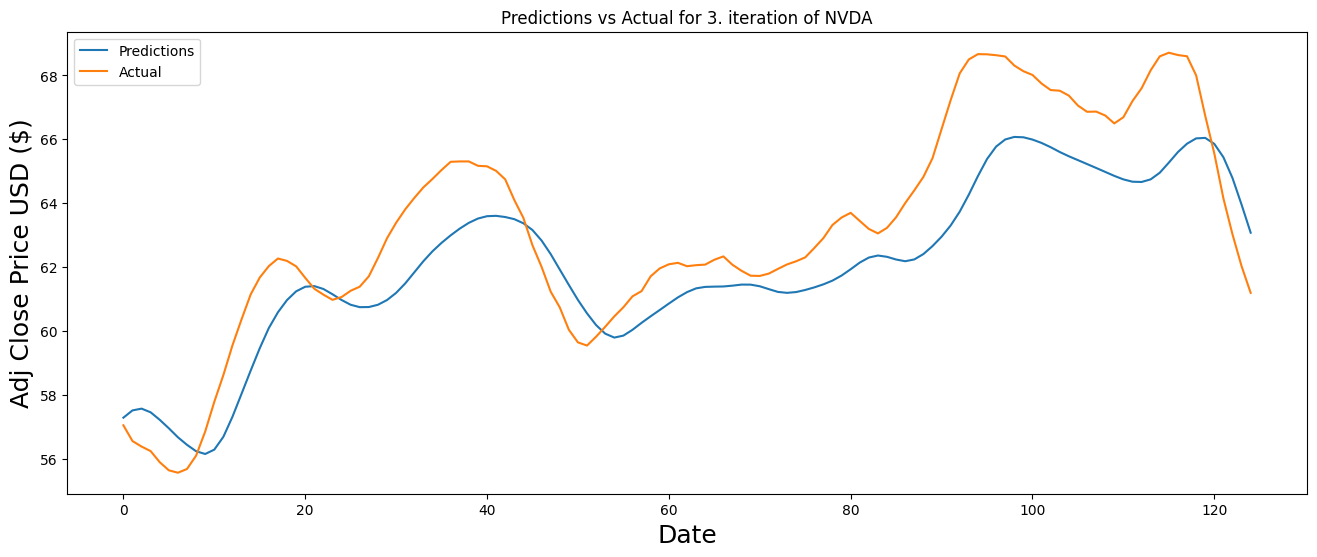

4/4 [==============================] - 2s 7ms/step
RSME: 0.06941299084822626


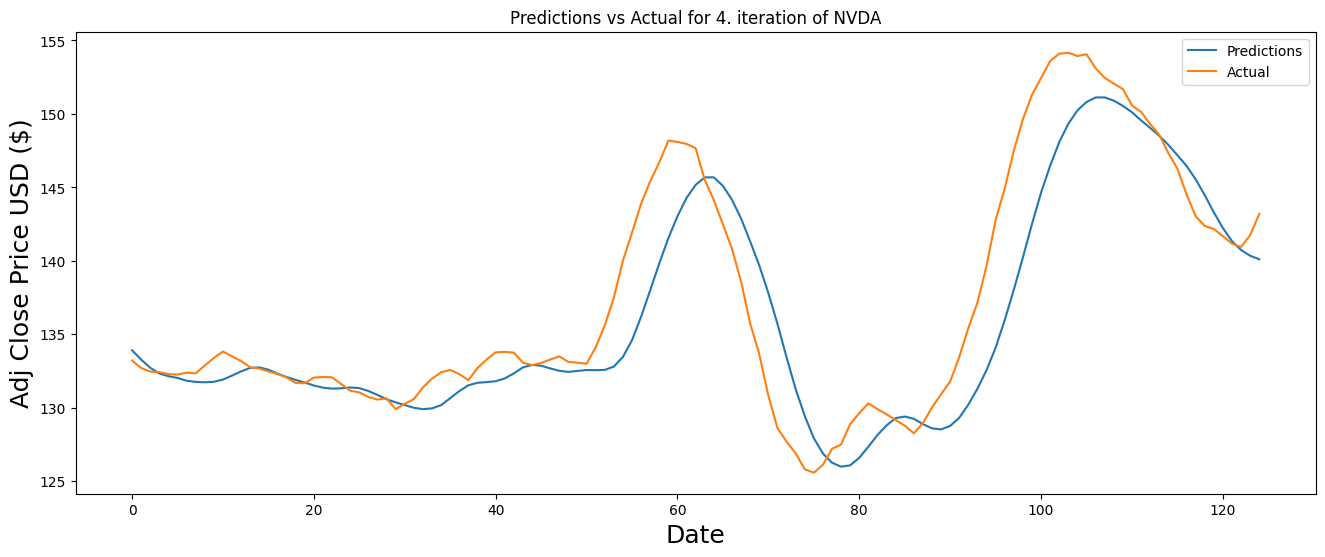

4/4 [==============================] - 2s 7ms/step
RSME: 0.09046841955267951


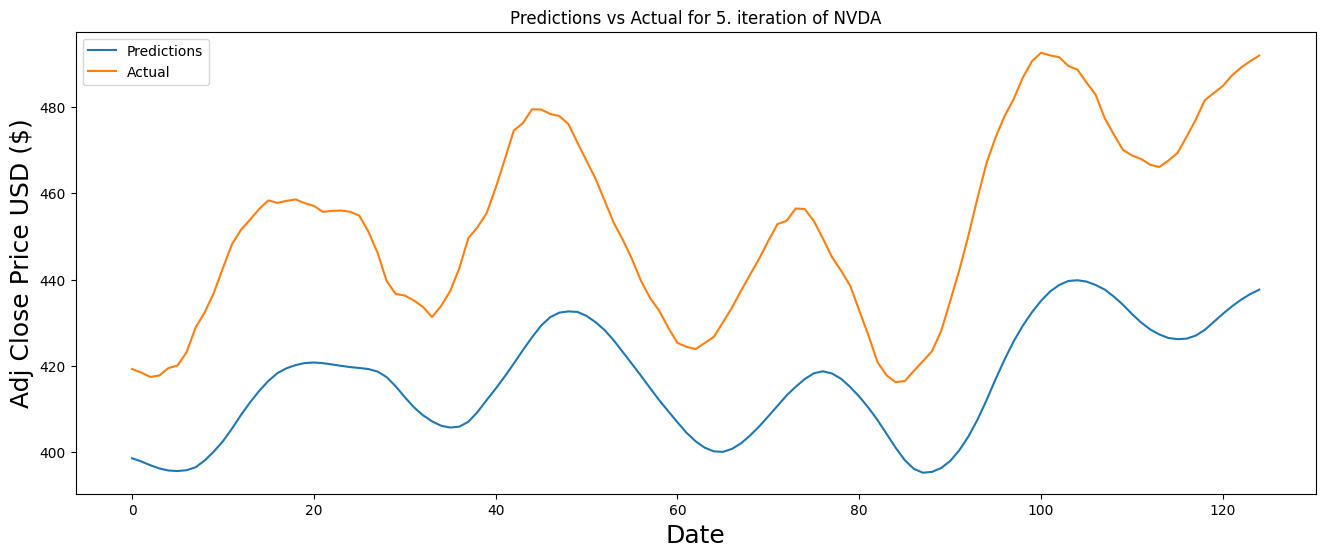

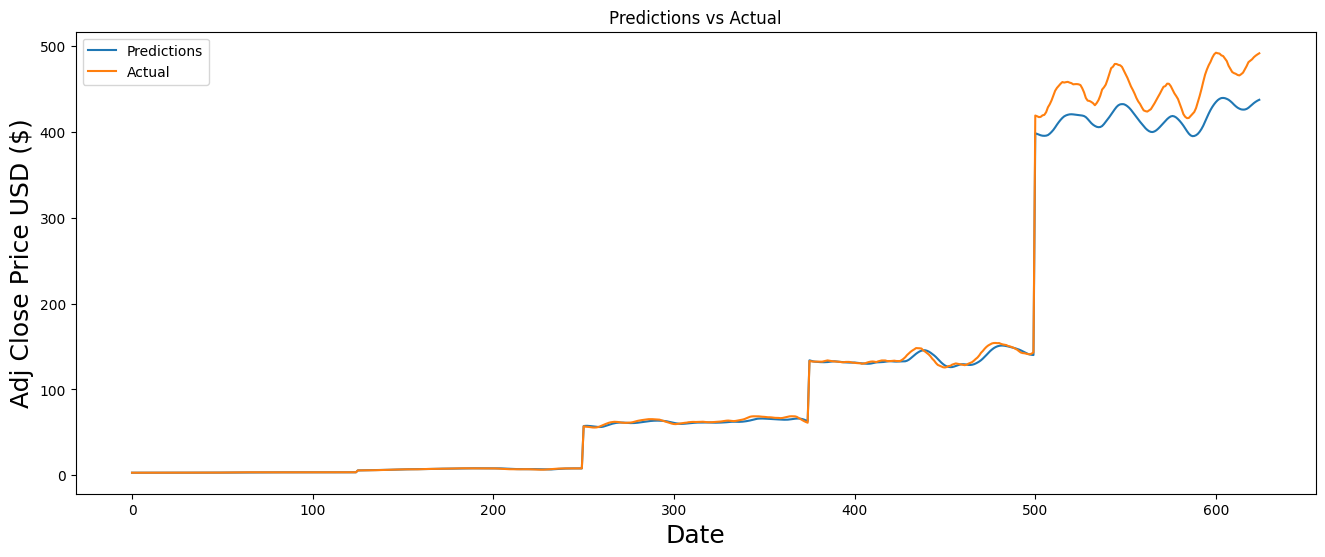

C:\Users\User\AppData\Local\Temp\ipykernel_40780\2236464972.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[start:end, column] = df.loc[start:end, column] / max_value


4/4 [==============================] - 2s 7ms/step
RSME: 0.33631830717472205


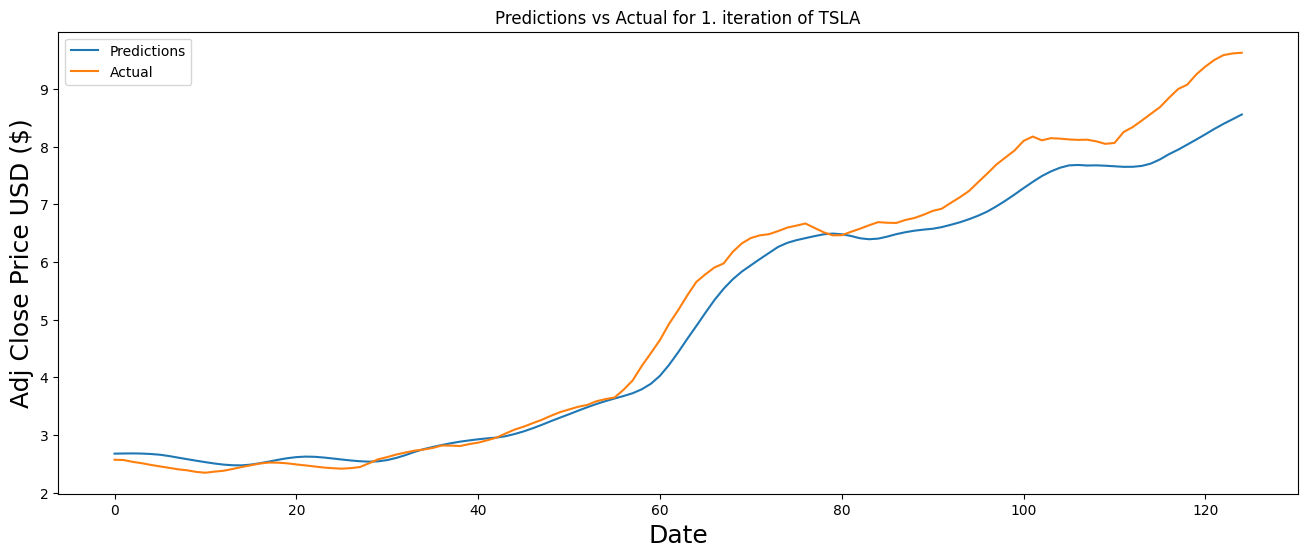

4/4 [==============================] - 2s 5ms/step
RSME: 0.1262602595904925


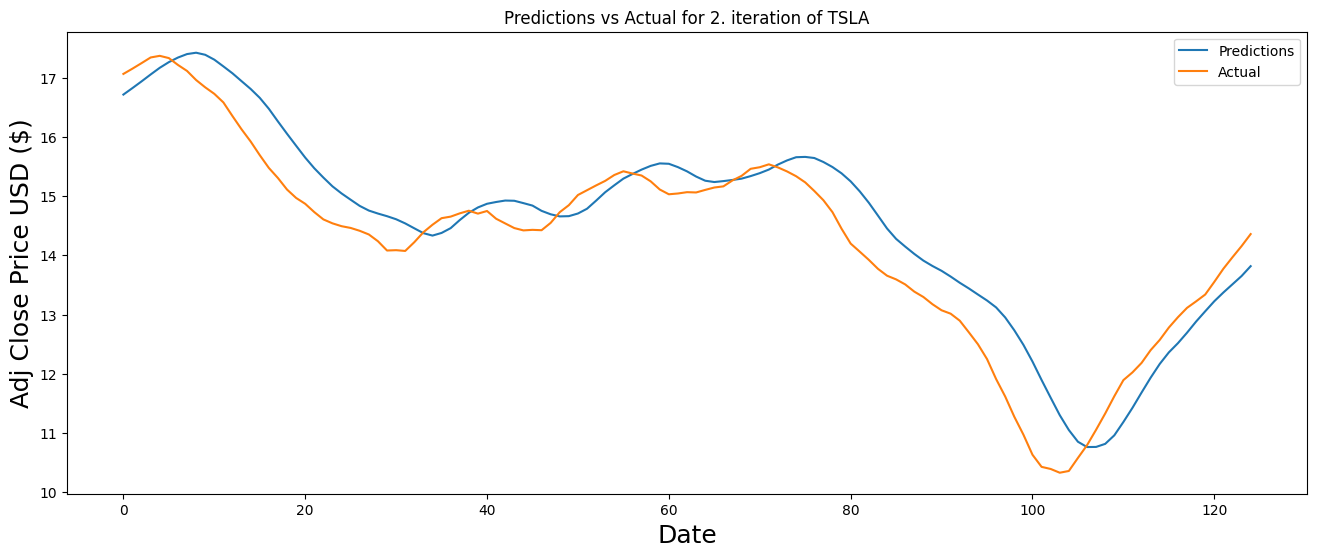

4/4 [==============================] - 2s 9ms/step
RSME: 0.08066745253607047


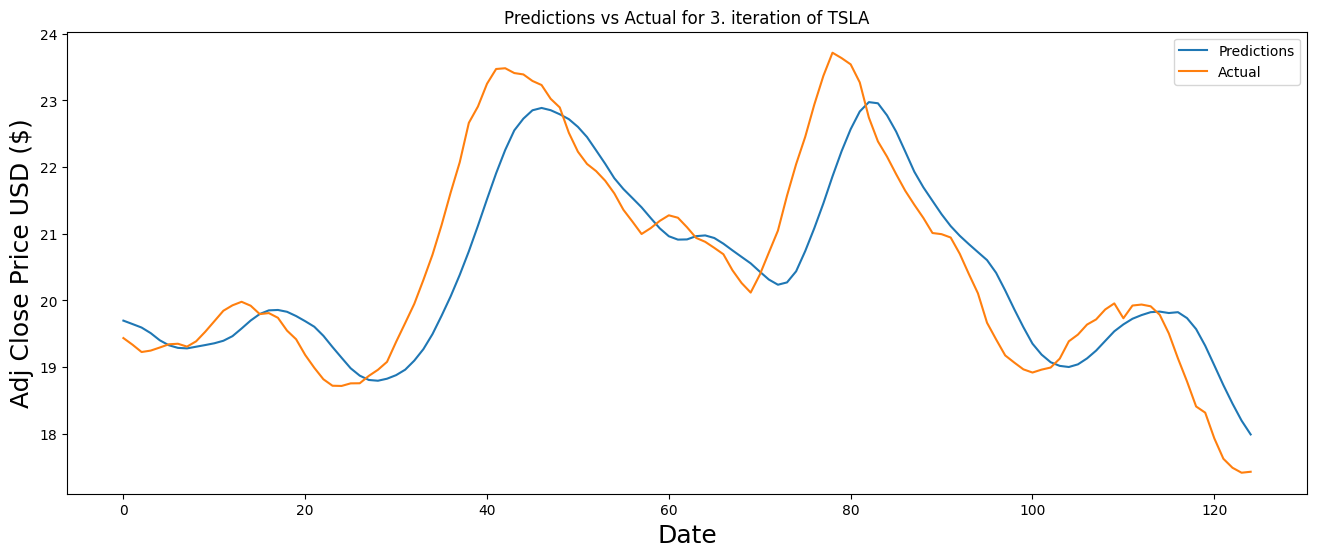

4/4 [==============================] - 2s 13ms/step
RSME: 0.17859409628523445


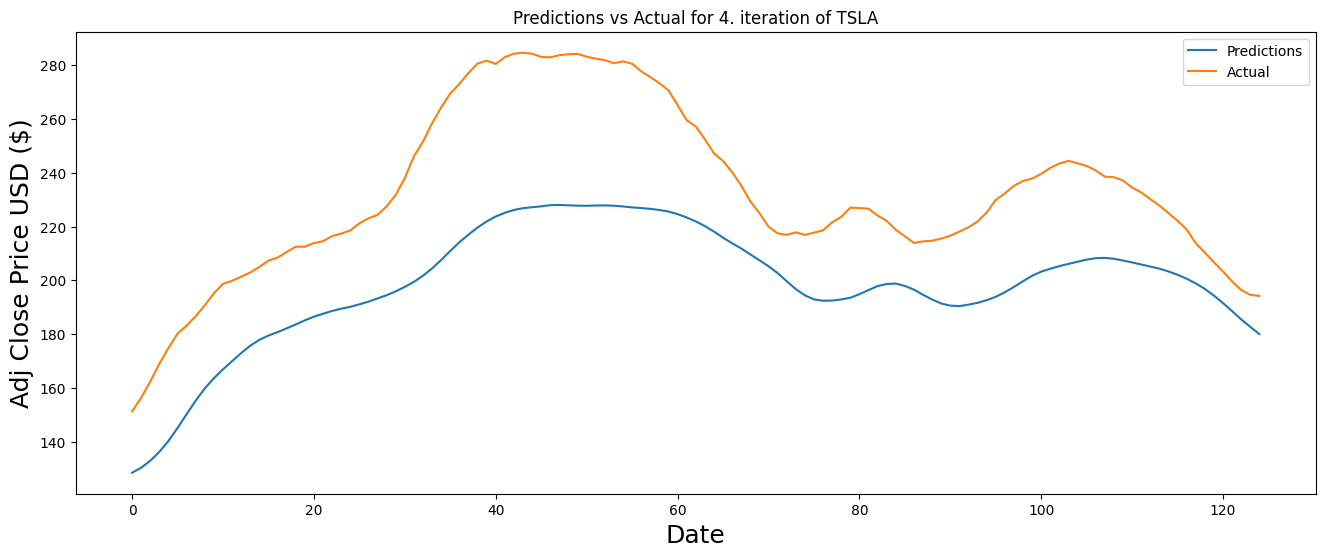

4/4 [==============================] - 1s 10ms/step
RSME: 0.06379730138497222


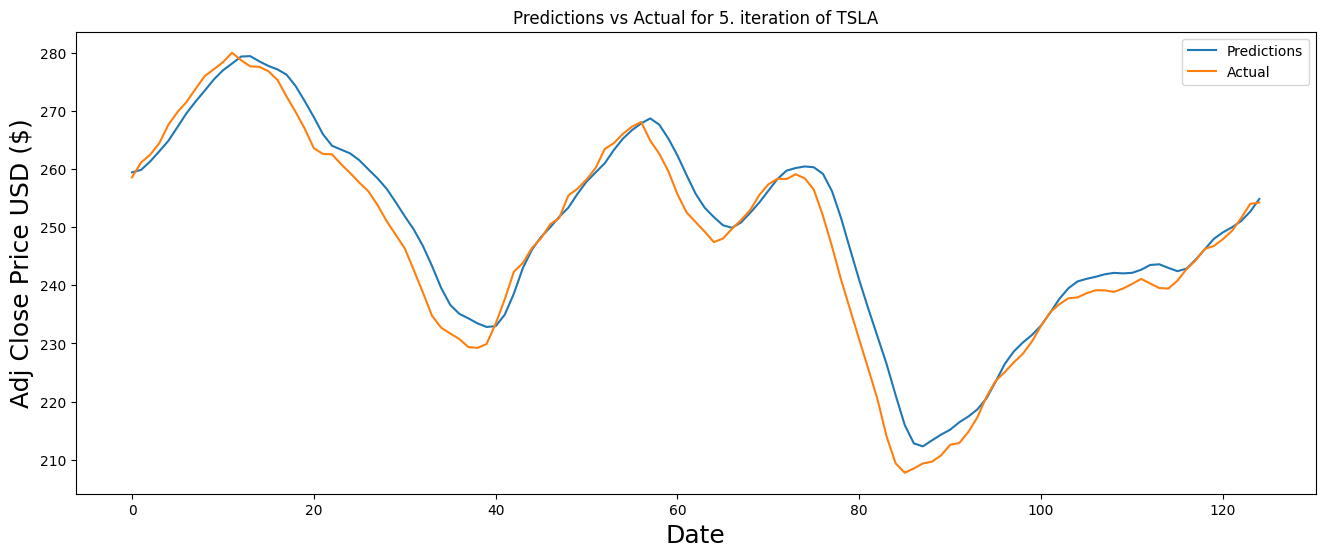

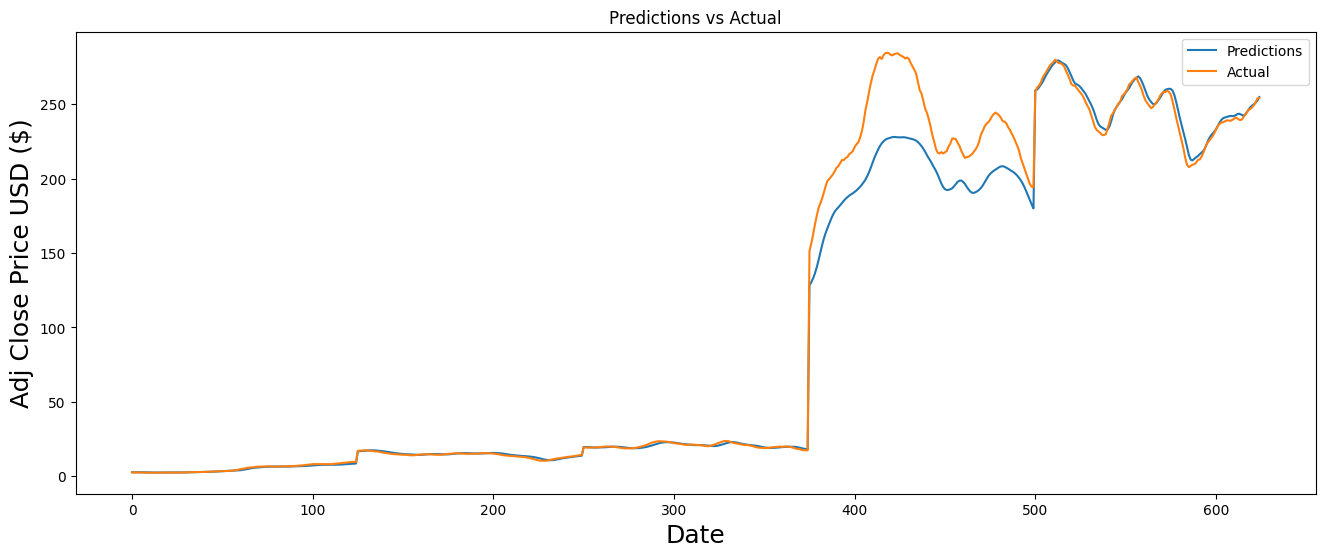

In [16]:
"""
Main function.
"""
files = os.listdir("../../data/processed")

for file in files:
    lstm_prediction("../../data/processed/" + file)